# Binary Logistic Regression

In this assignment we will use the logistic regression algorithm to classify flowers based on measurements of the sepal and petal legth and width.

Topics will cover:
* linear classification, decision boundaries
* logistic sigmoid function
* binary cross-entropy loss function
* gradient descent minimization algorithm
* logistic regression on the Iris dataset

## Iris dataset
This dataset consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length and width, stored in a 150x4 numpy.ndarray

The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.

![Iris vericolor](http://farm4.static.flickr.com/3360/3553041346_4bfa2d550b.jpg)


In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
import numpy as np
from ipywidgets import interact

%matplotlib inline

In [2]:
#load the dataset with sklearn
iris = datasets.load_iris()

In [3]:
print("Shape of the inputs: ", iris.data.shape)
print("Shape of the labels: ", iris.target.shape)

print("\nFirst 4 values from the data: ")
print("Inputs: \n", iris.data[:4, :])
print("Labels: ", iris.target[:4])

Shape of the inputs:  (150, 4)
Shape of the labels:  (150,)

First 4 values from the data: 
Inputs: 
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]]
Labels:  [0 0 0 0]


## Visualization

We use matplotlib scatter function to visualize the data. Since the data is 4 dimensional (and scatter plot can handle only two dimensional data) we visualize the data based on the first two features:

In [4]:
x = iris.data
y = iris.target

nr_features = x.shape[1]

In [9]:
def scatter_plot(x0, x1, y, feature_names, label_names, w=None):
    """
    x0, x1 : features
    y : labels
    feature_names: name of the features x0 and x1
    label_names: name of the labels y
    w: parameter of a hyperplane 
    """
    plt.figure(figsize=(9, 6))
    for i, label  in enumerate(label_names):
        target = y == i
        color = plt.cm.Set1.colors[i]
        plt.scatter(x0[target], x1[target], c=color, label=label)
    plt.legend()
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    
    if w is not None:
        x_min = x0.min() - 0.5
        x_max = x0.max() + 0.5
        
        x_line = np.linspace(x_min, x_max, 50)
        x1_line = np.stack((x_line, np.ones_like(x_line)), axis=1)
        
        y_line = np.matmul(x1_line, w[[0,2]]) / -w[1]
        plt.plot(x_line, y_line, '-')
        
        plt.xlim([x0.min() - 0.5, x0.max() + 0.5])
        plt.ylim([x1.min() - 0.5, x1.max() + 0.5])
    
    plt.show()

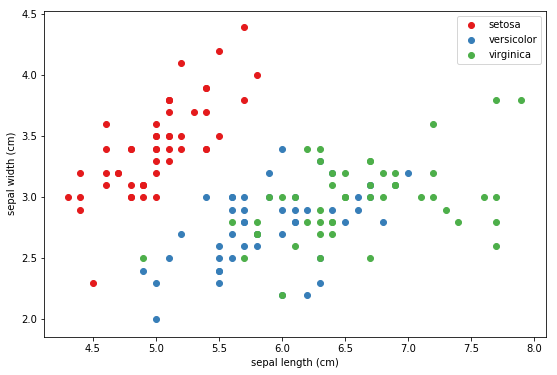

In [10]:
scatter_plot(x[:, 0], x[:, 1], y, iris.feature_names[:2], iris.target_names)

Good. Now visualize the data with scatterplot using all possible $i, j$ feature combination. Hint: use matplotlib's *add_subplot* function to add multiple subplots to the figure.

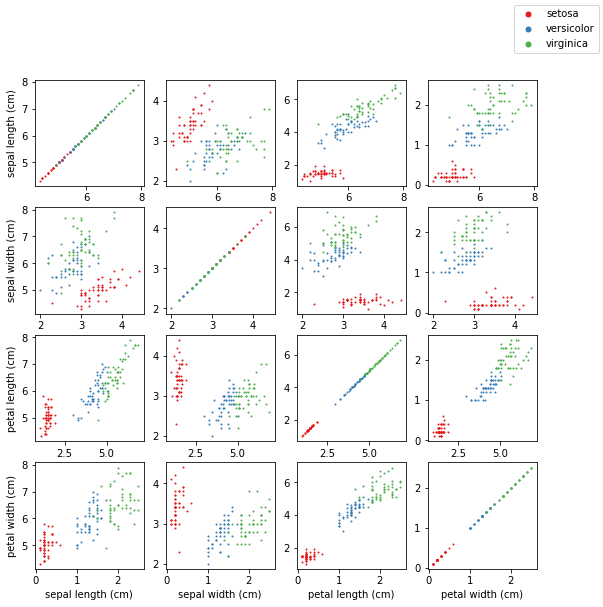

In [11]:
fig = plt.figure(figsize=(9,9))

for i in range(nr_features):
    for j in range(nr_features):
        ax = fig.add_subplot(nr_features, nr_features, i*nr_features+j+1)
        
        for k, label in enumerate(iris.target_names):
            target = y==k
            color = plt.cm.Set1.colors[k]     
            ax.scatter(x[target,i], x[target, j], s=1, c=color)
        
        if j == 0:
            ax.set_ylabel(iris.feature_names[i])
        if i == nr_features-1:
            ax.set_xlabel(iris.feature_names[j])


fig.legend(iris.target_names, markerscale=5)
         
plt.savefig('iris_scatterplot_new.png')
plt.show()

## Logistic regression

By analysing the scatterplot above, we can see that the setosa flower can be separated from the other two flowers using a line. Moreover, it is enough to use only two features (insted of using all the four features) to do this separation.

Choose two features from the dataset and try to define a line ($w_1 x + w_2 y + w_3 = 0$) such that the line separates the setosa flower from the rest.

In [12]:
# Tune these values (manually)
w = np.array([5, -0.5, -10])

feature_idx_0 = 2 # choose a feature
feature_idx_1 = 0 # choose an other feature

x0 = x[:, feature_idx_0]   
x1 = x[:, feature_idx_1]

def interactive_scatterplot(w0, w1, w2):
    scatter_plot(x0, x1, y, [iris.feature_names[feature_idx_0], 
                iris.feature_names[feature_idx_1]], iris.target_names, 
                np.array([w0, w1, w2]))
    
interact(interactive_scatterplot, w0=(-10, 10, 0.5), w1=(-10, 10, 0.5), w2=(-10, 10, 0.5))

interactive(children=(FloatSlider(value=0.0, description='w0', max=10.0, min=-10.0, step=0.5), FloatSlider(val…

<function __main__.interactive_scatterplot(w0, w1, w2)>

Now that we plotted the line, we can easily see that all *setosa* samples are separated from the *versicolor* and *virginica* samples. But how can we decide algorithmically if two samples are on the same or the different sides of the separating line?

The answer will become clear if we plot the $sign(w_1 x + w_2 y + w_3)$ function:

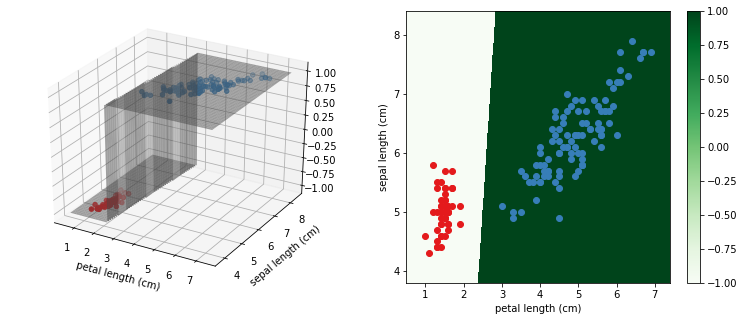

In [13]:
w = np.array([5, -0.5, -10])

xx = np.linspace(x0.min() - 0.5, x0.max() + 0.5, 1000)
yy = np.linspace(x1.min() - 0.5, x1.max() + 0.5, 1000)

xx, yy = np.meshgrid(xx, yy)

xy1 = np.stack((xx, yy, np.ones_like(xx)), axis=-1)

signx = np.sign(xy1 @ w) # @ operator denotes matrix multiplication


# Plot
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x0[y==0], x1[y==0], -np.ones_like(y[y==0]), c=plt.cm.Set1.colors[0])
ax.scatter(x0[y!=0], x1[y!=0], np.ones_like(y[y!=0]), c=plt.cm.Set1.colors[1])

ax.plot_surface(xx, yy, signx, color='gray', alpha=0.5)

ax.set_xlabel(iris.feature_names[feature_idx_0])
ax.set_ylabel(iris.feature_names[feature_idx_1])

ax = fig.add_subplot(122)
h = ax.pcolormesh(xx, yy, signx, cmap=plt.cm.Greens)
plt.colorbar(h)
ax.scatter(x0[y==0], x1[y==0], c=plt.cm.Set1.colors[0])
ax.scatter(x0[y!=0], x1[y!=0], c=plt.cm.Set1.colors[1])
ax.set_xlabel(iris.feature_names[feature_idx_0])
ax.set_ylabel(iris.feature_names[feature_idx_1])

plt.show()

### Logistic sigmoid function

The plot shows us, that we can easily guess on which side we are if we look at the value of the $sign(w_1 x + w_2 y + w_3)$ expression. So given a set of parameters $(w_1, w_2, w_3)$ of a line that separates the classes, we can easily make predictions by plugging the new $(x, y)$ values in the equation, and check the value. 

There is however a problem: we also want to **learn** the optimal $\boldsymbol{w}$ values. This will involve the differentiation of loss function (a function of our predictions and the ground-truth) w.r.t. the vector $\boldsymbol{w}$. The *sign* function will not help us, as its gradient is 0 almost anywhere.

But we can fix that! We can replace the *sign* with the **logistic sigmoid** function (-> *logistic* regression):

\begin{equation} \sigma(x) = \frac{1}{1 + e^{-x}} \end{equation}

Let's plot the sigmoid and signed (scaled to return {0, 1}) function

In [14]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

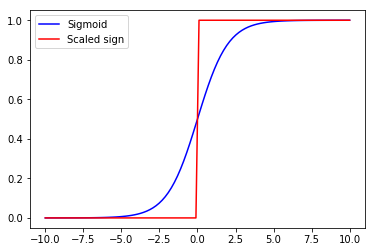

In [15]:
x_range = np.linspace(-10, 10, 100)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_range, sigmoid(x_range), c='b', label='Sigmoid')
ax.plot(x_range, (np.sign(x_range) + 1) / 2, c='r', label='Scaled sign')
ax.legend()
plt.show()

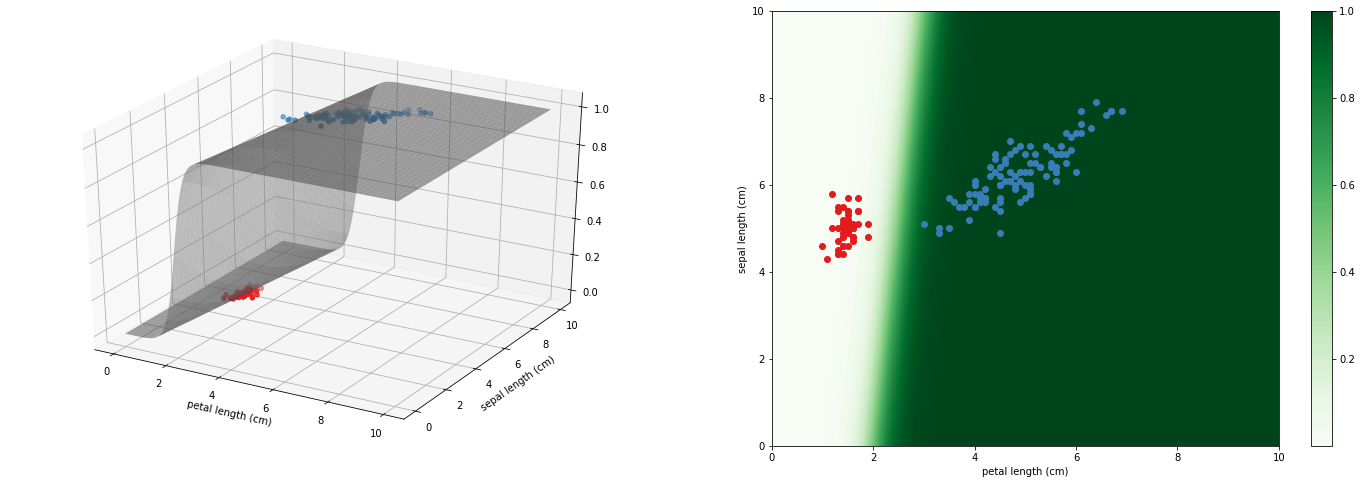

In [16]:
w = np.array([5, -0.5, -10])

xx = np.linspace(0, 10, 1000)
yy = np.linspace(0, 10, 1000)

xx, yy = np.meshgrid(xx, yy)

xy1 = np.stack((xx, yy, np.ones_like(xx)), axis=-1)

# z = 1/(1+np.exp(-np.matmul(xy1.transpose((1,2,0)), w)))
sigmax = 1 / (1 + np.exp(-xy1 @ w))

# Plot
fig = plt.figure(figsize=(25,8))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x0[y==0], x1[y==0], y[y==0], c=plt.cm.Set1.colors[0])
ax.scatter(x0[y!=0], x1[y!=0], np.ones_like(y[y!=0]), c=plt.cm.Set1.colors[1])

ax.plot_surface(xx, yy, sigmax, color='gray', alpha=0.5)

ax.set_xlabel(iris.feature_names[feature_idx_0])
ax.set_ylabel(iris.feature_names[feature_idx_1])

ax = fig.add_subplot(122)
h = ax.pcolormesh(xx, yy, sigmax, cmap=plt.cm.Greens)
plt.colorbar(h)
ax.scatter(x0[y==0], x1[y==0], c=plt.cm.Set1.colors[0])
ax.scatter(x0[y!=0], x1[y!=0], c=plt.cm.Set1.colors[1])
ax.set_xlabel(iris.feature_names[feature_idx_0])
ax.set_ylabel(iris.feature_names[feature_idx_1])

plt.show()

### Loss function

In order to be able to optimize the model parameters $\boldsymbol{w}$, we need to know how good or bad our current model is on the training dataset. The loss function does exactly that. In this section we will look at the loss function of the binary logistic regression model: the **binary cross-entropy** function.

First of all let's clear the notations: 
  * $\{\boldsymbol{x_i}, y_i\}_{i=1..n}$ is our training dataset with $n$ training samples
  * $\boldsymbol{X} = [\boldsymbol{x_1} \dots \boldsymbol{x_n}]^T$ is the training data, a $n \times 3$ matrix
  * $\boldsymbol{y} = (y_1, \dots, y_n)$ are the ground-truth labels, each one of them taking values 0 (setosa) or 1 (versicolor or virginica)
  * $\boldsymbol{\hat{y}} = (\hat{y_1}, \dots, \hat{y_n})$ are the model predictions. Each $\hat{y_i} = \sigma(\boldsymbol{w^Tx_i})$ takes its values from the $(0, 1)$ interval
  * $\boldsymbol{w} = (w_1, w_2, w_3)$ are the model parameters
  
We can interpret the $y_i$ values as the probabilities of the output being 1:
\begin{equation}
\hat{y_i} = p(y_i=1 | \boldsymbol{x_i}, \boldsymbol{w}) \\
1 - \hat{y_i} = p(y_i=0 | \boldsymbol{x_i}, \boldsymbol{w}) 
\end{equation}

We can combine these two into a single probability:
\begin{equation}
p(y_i|\boldsymbol{x_i}, \boldsymbol{w}) = \hat{y_i}^{y_i} (1 - \hat{y_i})^{1 - y_i}
\end{equation}

Observe that when the true label $y_i = 1$, the second term is 1, yielding $\hat{y_i}$, and when $y_i = 0$, the first term is 1, yielding $1 - \hat{y_i}$  (exactly what we needed).

Making the assumption that samples are independent from each other, we can multiply the probabilities to get the probability of the whole dataset, also called the *likelihood* of the dataset:

\begin{equation}
p(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{w}) = \prod_{i=1}^n p(y_i|\boldsymbol{x_i}, \boldsymbol{w}) = \prod_{i=1}^n \hat{y_i}^{y_i} (1 - \hat{y_i})^{1 - y_i}
\end{equation}

Finding the optimal $\boldsymbol{w}$ values is equivalent to  maximizing the likelihood function, i.e. finding the model that has the highest probability of generating our training data. We have to problems with that:
* Multiplying together a lot of small values is numerically unstable $\rightarrow$ we will maximize instead the natural logarithm of the likelihood, which transforms the product into a sum
* We are usually doing a minimization, and not a maximization $\rightarrow$ we will take the negative of the log-likelihood

The final binary cross-entropy cost function:
\begin{equation}
\begin{aligned}
\mathcal{L}(\boldsymbol{w}) &= - \ln p(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{w}) = \\
 &= -\ln \prod_{i=1}^n p(y_i|\boldsymbol{x_i}, \boldsymbol{w}) = \\
 &= -\sum_{i=1}^{n} \ln p(y_i|\boldsymbol{x_i}, \boldsymbol{w}) = \\
 &= -\sum_{i=1}^{n} -\ln \hat{y_i}^{y_i} (1 - \hat{y_i})^{1 - y_i} = \\
 &= -\sum_{i=1}^{n} y_i \ln \hat{y_i} + (1 - y_i) \ln (1 - \hat{y_i})
\end{aligned}
\end{equation}

And that's it! :) 
If you want to dig deeper, you can find a nice reading on comparing distributions [here](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained).

Okay, now the implementation:

In [17]:
def binary_cross_entropy(y_hat, y):
    return -np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

Evaluating some models:

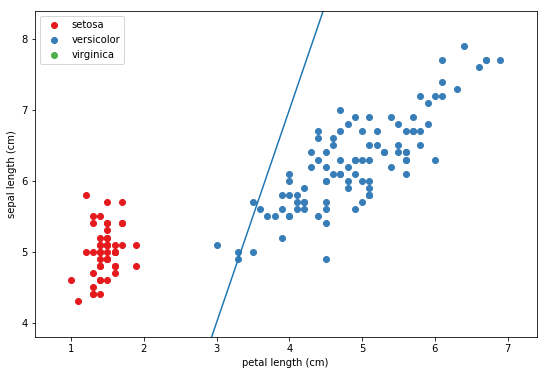

Loss(w1) =  11.841691720703434


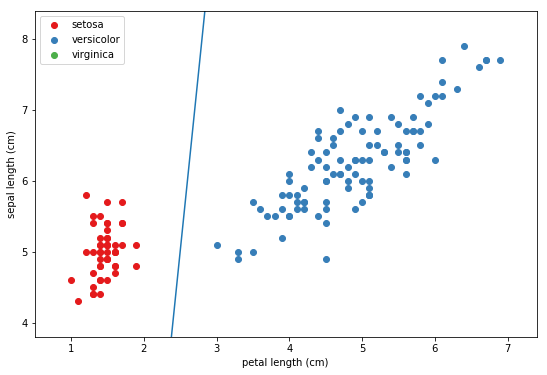

Loss(w2) =  0.5622056235004546


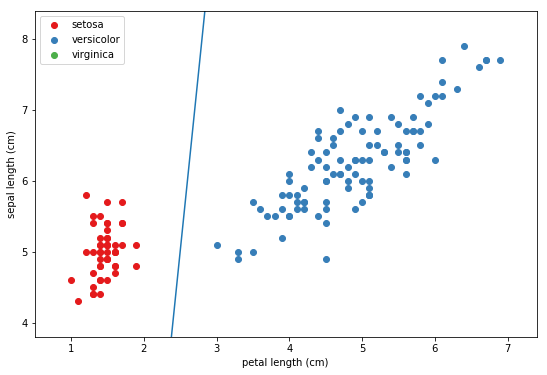

Loss(w3) =  0.08333080232326172


In [18]:
X = np.stack((x0, x1, np.ones_like(x0)), axis=-1)
y[y>0] = 1

w1 = np.array([3, -1, -5])
w2 = np.array([5, -0.5, -10])
w3 = 1.5 * w2


scatter_plot(x0, x1, y, [iris.feature_names[feature_idx_0], iris.feature_names[feature_idx_1]], iris.target_names, w1)
y_hat = sigmoid(X @ w1)
loss = binary_cross_entropy(y_hat, y)
print("Loss(w1) = ", loss)

scatter_plot(x0, x1, y, [iris.feature_names[feature_idx_0], iris.feature_names[feature_idx_1]], iris.target_names, w2)
y_hat = sigmoid(X @ w2)
loss = binary_cross_entropy(y_hat, y)
print("Loss(w2) = ", loss)

scatter_plot(x0, x1, y, [iris.feature_names[feature_idx_0], iris.feature_names[feature_idx_1]], iris.target_names, w2)
y_hat = sigmoid(X @ w3)
loss = binary_cross_entropy(y_hat, y)
print("Loss(w3) = ", loss)

### Gradient Descent

Given the loss function (also called cost function) above we would like to find a $\boldsymbol{w}^*$ for  which the loss is minimal:
\begin{equation}
\arg\min_w \cal{L(\boldsymbol{w})} 
\end{equation}
Basically, we want to find the deepest valley in the function. 
The process of finding $\boldsymbol{w}^*$ is called optimization. There are different algorithms for this but the most comonly used is **gradient descent**. 


How does it work? A simple way to understand gradient descent is to use  following analogy: **Imagine that you are on a hill** Me and you would like to go down into the valley. Since the weather is foggy, you cannot see the valley, only the place around you. What would you do? You look around and make a step downwards. Now you look around again and make an other step. By repeating this you can reach the valley (in case there is only one valley :) )

Gradient descent algorithm finds the minimum of a function in the same way. It starts from some initial position on the hill (some initial $\boldsymbol{w}$), it looks around (calculates the derivative of function with respect to $\boldsymbol{w}$) and makes a step (**modifies** the value of $\boldsymbol{w}$ based on the gradient and a hyperparameter called **learning rate**)

Let's try this with a simple example. 

Given a quadratic function: 
\begin{equation}
f(x) = 2x^2 - 3x + 5
\end{equation}

We would like to find its minimum starting from position $x_0$.  

Gradient descent algorithm: 
1.  calculate the gradient of $f$ with respect to $x$ in position $x_0$:  $\frac{\partial f}{\partial{x}}(x_0) = 4x_0 -3$
2.  make a small step in the oposit direction of the gradient: $x_0 = x_0 - \eta \frac{\partial f}{\partial{x}}(x_0)$
3.  go back to step 1.


Why do we need the learning rate? During gradient descent we want to make small steps. Making a  big step would lead closer to the minimum but we may jump too big ending up in the oposite side of the valley. 

The $f(x)$ function, its tangent in $x_0$, and the negative gradient is is here:

In [19]:
def plot_function(x_0):
    def func(x):
        return 2*x**2 -3*x + 5

    def gradient(x):
        return 4 * x - 3

    def tangent(x, a, b):
        return a*x + b


    x = np.linspace(-5, 5, 10000)
    y = func(x)


    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot('111')

    # plot the square function
    ax.plot(x, y, c='b')

    #plot its tangent at point x_0
    a = gradient(x_0)
    b = func(x_0) - a*x_0
    ax.plot(x, tangent(x, a, b), c='g')

    # plot the tangent equation
    tangent_eq = '$'+str(a) + "x_0 + "+str(b)+'$'
    ax.text(x_0 - 2.5, func(x_0)+5, tangent_eq, fontsize=18, color='g')

    # plot the direction of the gradient
    lr = 0.1    #lr is usually smaller than 0.1
    ax.quiver(x_0, func(x_0), -lr*a, 0, scale_units='x', scale=1, color='r')

    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)')

    plt.xlim(x.min(), x.max())
    plt.ylim(y.min()-10, y.max())

    plt.show

def interactive_plot_function(x_0):
    return plot_function(x_0)

In [20]:
interact(plot_function, x_0=(-5, 5, 0.1))

interactive(children=(FloatSlider(value=0.0, description='x_0', max=5.0, min=-5.0), Output()), _dom_classes=('…

<function __main__.plot_function(x_0)>

## Differentiating the cross-entropy loss w.r.t. the logistic regression parameters

We can split the loss computation for a single example into 3 steps: 

\begin{equation}
\begin{aligned} 
  z_i &= \boldsymbol{w^T x_i} \\
  \hat{y_i} &= \sigma(z_i) \\
  \mathcal{L}(\boldsymbol{w}) &= -\sum_{i=1}^{n} y_i \ln \hat{y_i} + (1 - y_i) \ln (1 - \hat{y_i})
\end{aligned}
\end{equation}

We need the gradient of the loss function w.r.t. parameters $\boldsymbol{w}$. Using the derivative chain rule, we get:

\begin{equation}
\nabla_{\boldsymbol{w}} \mathcal{L} = \frac{\partial \mathcal{L}}{\partial \boldsymbol{w}} = \sum_{i=1}^n \frac{\partial \mathcal{L}}{\partial \hat{y_i}} \frac{\partial \hat{y_i}}{\partial z_i} \frac{\partial z_i}{\partial \boldsymbol{w}}
\end{equation}

The partial derivatives are: 

\begin{equation}
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \hat{y_i}} &= - \frac{y_i}{\hat{y_i}} + \frac{1 - y_i}{1 - \hat{y_i}} \\
\frac{\partial \hat{y_i}}{\partial z_i} &= \hat{y_i} (1 - 
\hat{y_i}) \\
\frac{\partial z_i}{\partial \boldsymbol{w}} &= \boldsymbol{x_i} 
\end{aligned}
\end{equation}

Putting it together we get: 

\begin{equation}
  \nabla_{\boldsymbol{w}} \mathcal{L} = \sum_{i=1}^n (\hat{y_i} - y_i) \boldsymbol{x_i}
\end{equation}

In [21]:
def bce_gradient(X, y, y_hat):
  return np.sum((y_hat - y).reshape((-1, 1)) * X, axis=0).squeeze()

# Traning the model

/home/pszabolcs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


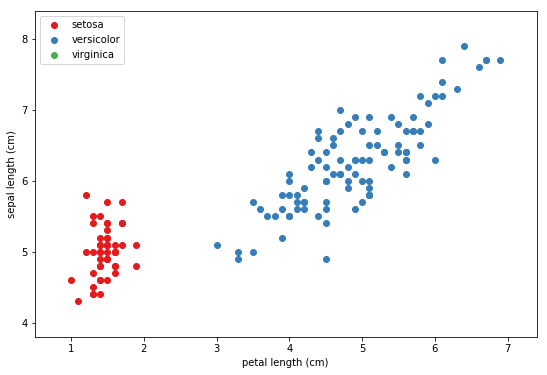

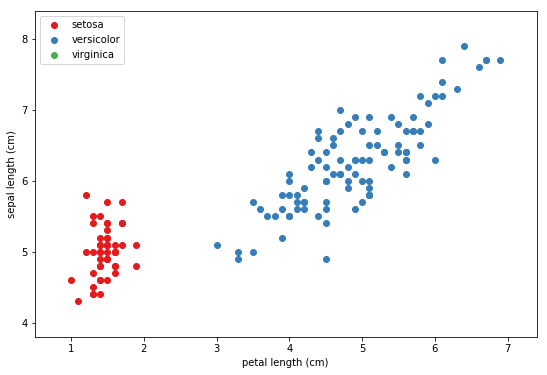

Step: 0, Loss: 103.9720770839918, Accuracy: 0.3333333333333333


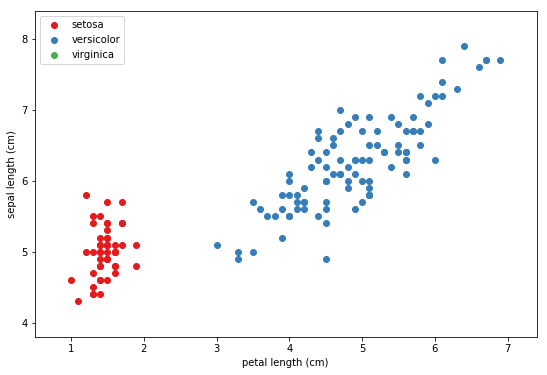

Step: 10, Loss: 79.79696745791031, Accuracy: 0.6666666666666666


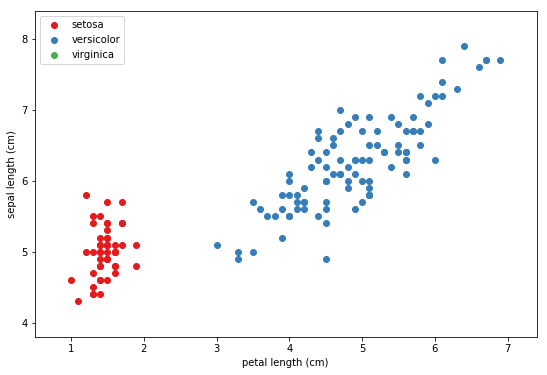

Step: 20, Loss: 75.14482328841805, Accuracy: 0.6666666666666666


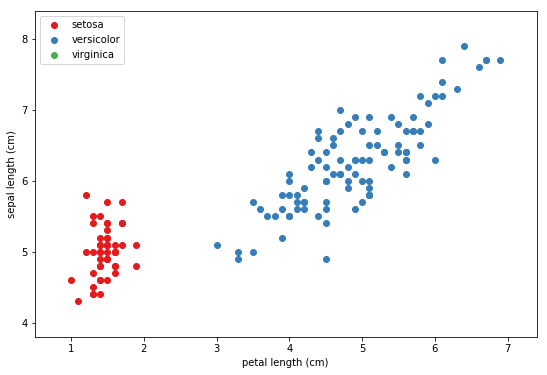

Step: 30, Loss: 71.31362635993615, Accuracy: 0.6666666666666666


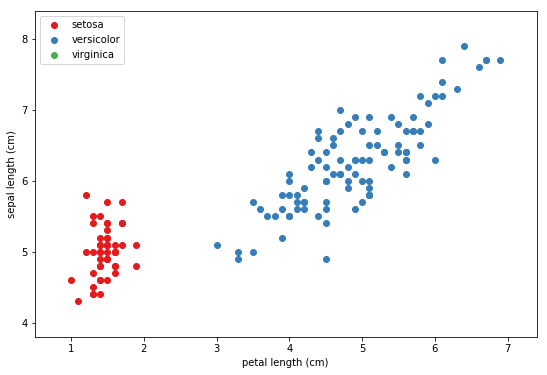

Step: 40, Loss: 67.78572214908522, Accuracy: 0.6666666666666666


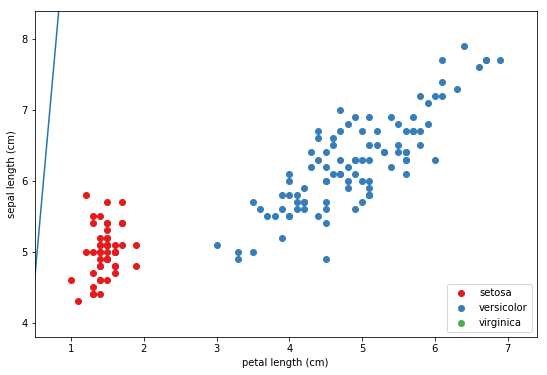

Step: 50, Loss: 64.51854951541277, Accuracy: 0.6666666666666666


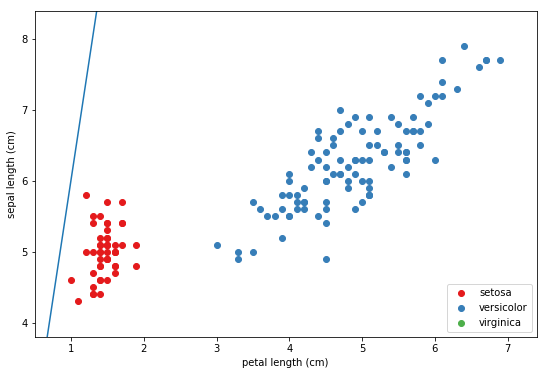

Step: 60, Loss: 61.491558001304305, Accuracy: 0.6666666666666666


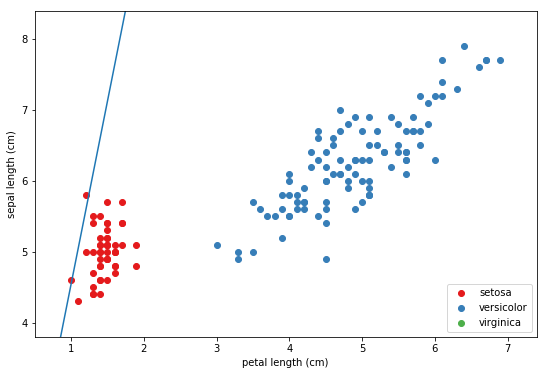

Step: 70, Loss: 58.68596329935889, Accuracy: 0.68


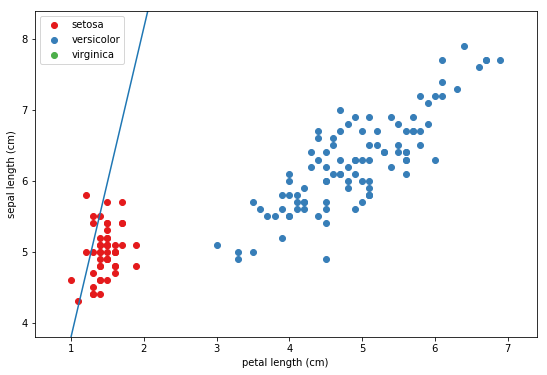

Step: 80, Loss: 56.083953315385564, Accuracy: 0.7066666666666667


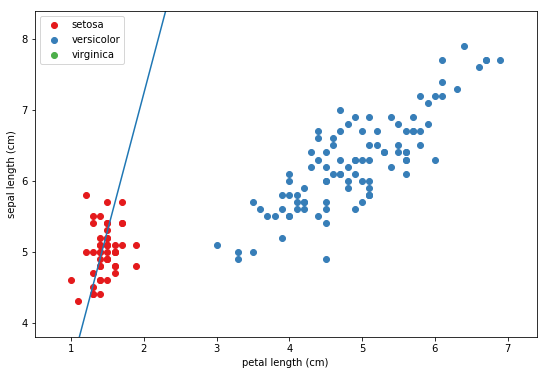

Step: 90, Loss: 53.668789992033425, Accuracy: 0.7866666666666666


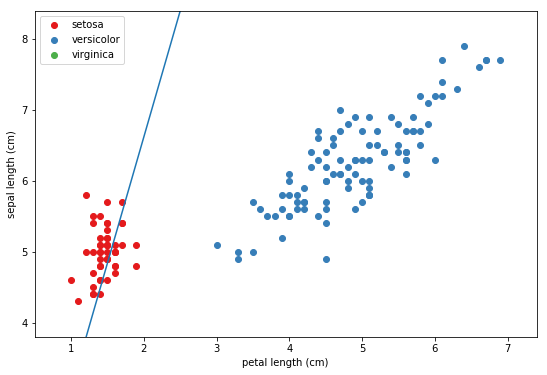

Step: 100, Loss: 51.42488360067189, Accuracy: 0.9066666666666666


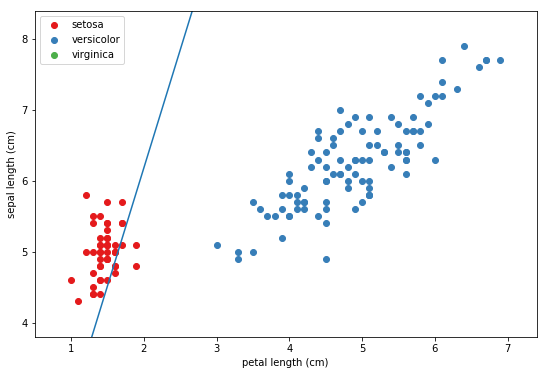

Step: 110, Loss: 49.33781510095903, Accuracy: 0.96


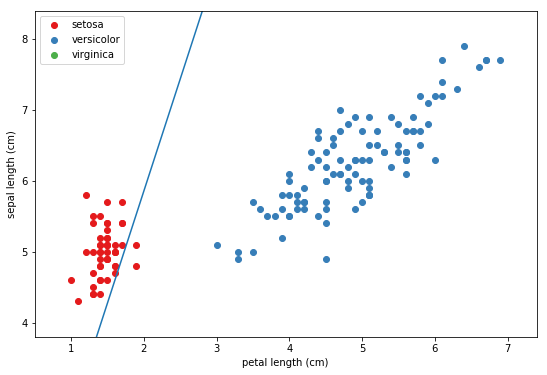

Step: 120, Loss: 47.3943208653, Accuracy: 0.9866666666666667


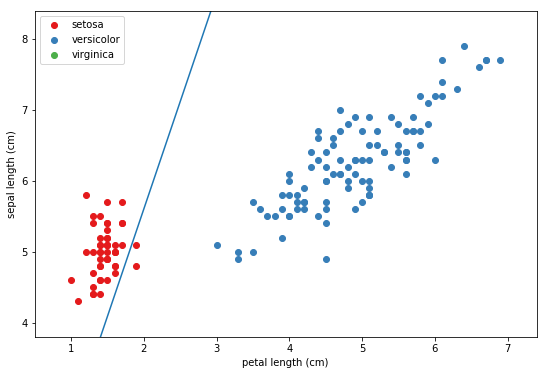

Step: 130, Loss: 45.582251666158825, Accuracy: 0.9866666666666667


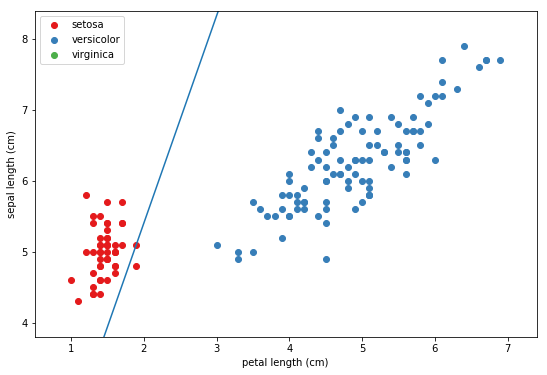

Step: 140, Loss: 43.89051497486535, Accuracy: 0.9866666666666667


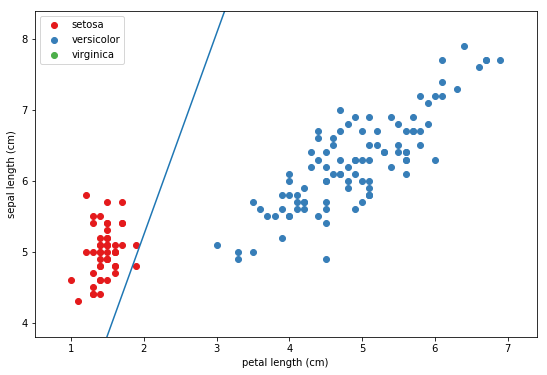

Step: 150, Loss: 42.30900740848208, Accuracy: 0.9933333333333333


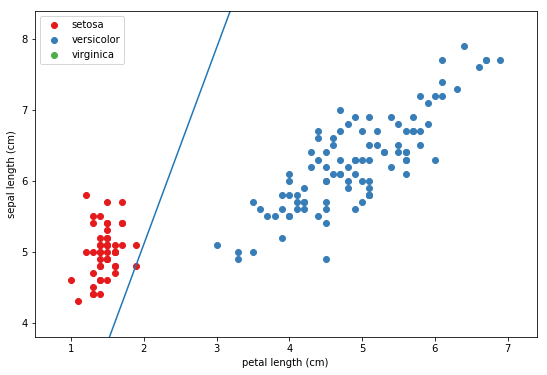

Step: 160, Loss: 40.82854238164012, Accuracy: 0.9933333333333333


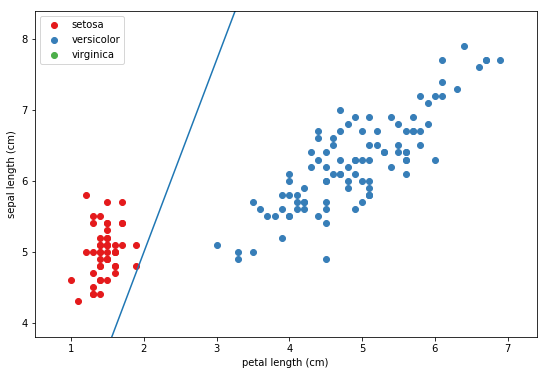

Step: 170, Loss: 39.44077659350923, Accuracy: 1.0


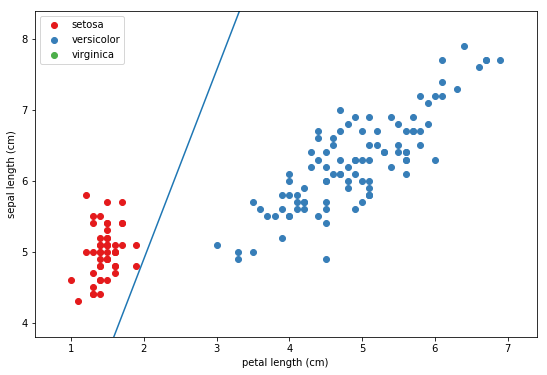

Step: 180, Loss: 38.13813786135383, Accuracy: 1.0


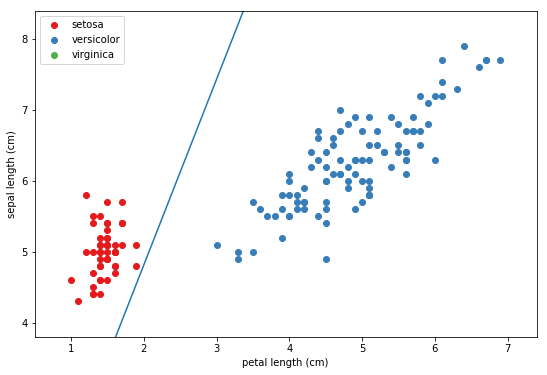

Step: 190, Loss: 36.91375595688213, Accuracy: 1.0


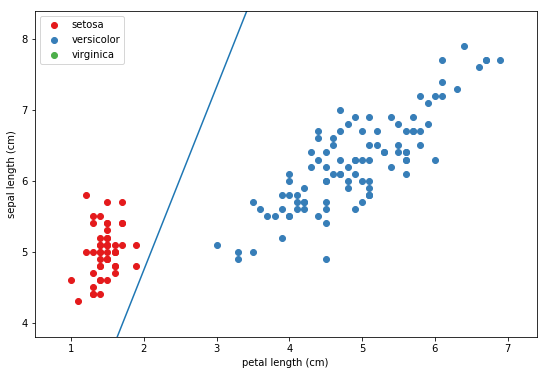

Step: 200, Loss: 35.76139746384947, Accuracy: 1.0


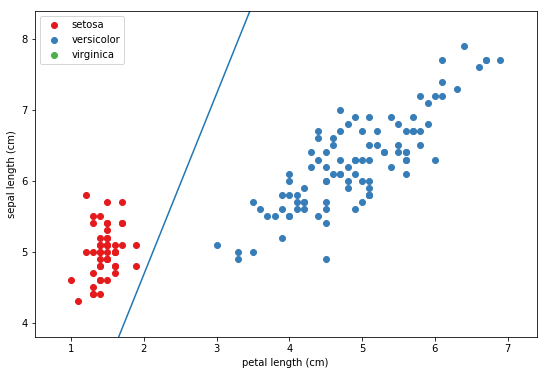

Step: 210, Loss: 34.67540521148101, Accuracy: 1.0


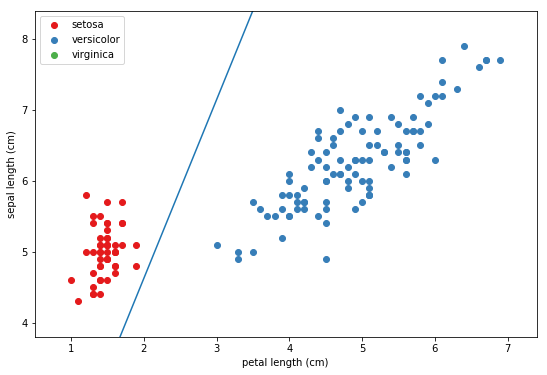

Step: 220, Loss: 33.65064250962786, Accuracy: 1.0


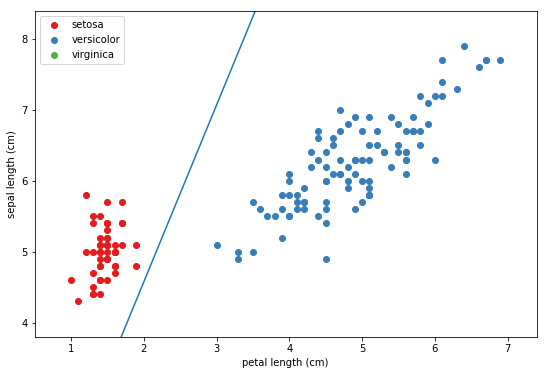

Step: 230, Loss: 32.682442185741394, Accuracy: 1.0


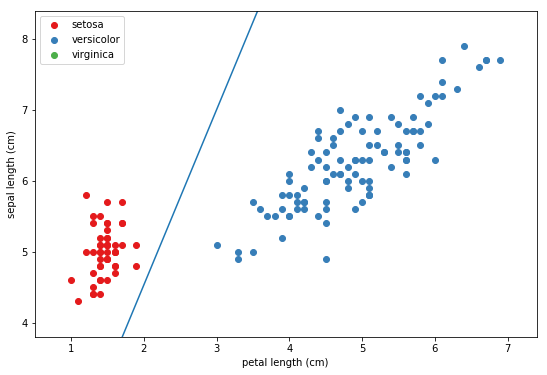

Step: 240, Loss: 31.76656027450585, Accuracy: 1.0


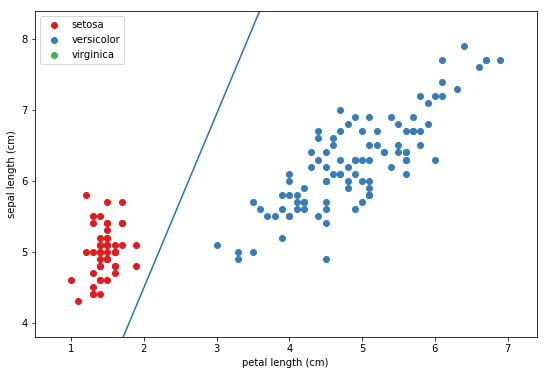

Step: 250, Loss: 30.899134117676034, Accuracy: 1.0


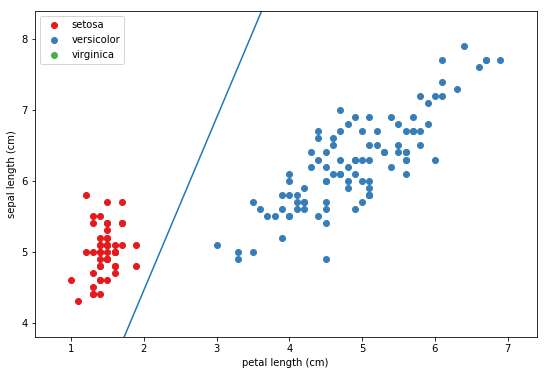

Step: 260, Loss: 30.076644578455067, Accuracy: 1.0


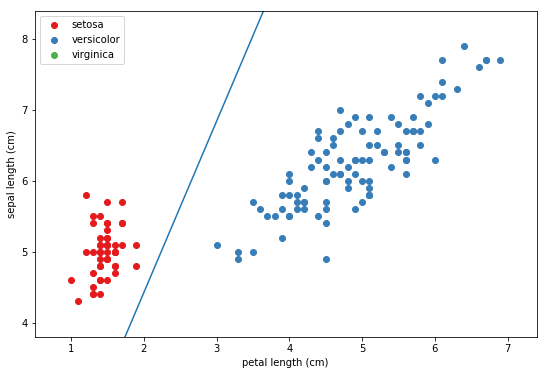

Step: 270, Loss: 29.29588204963734, Accuracy: 1.0


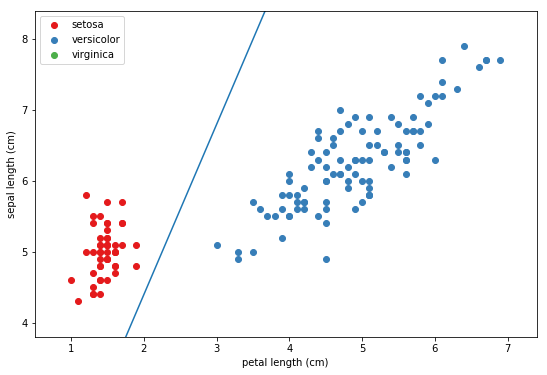

Step: 280, Loss: 28.553915928837426, Accuracy: 1.0


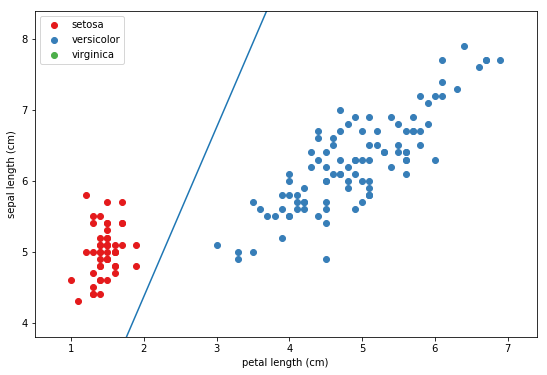

Step: 290, Loss: 27.848067240920344, Accuracy: 1.0


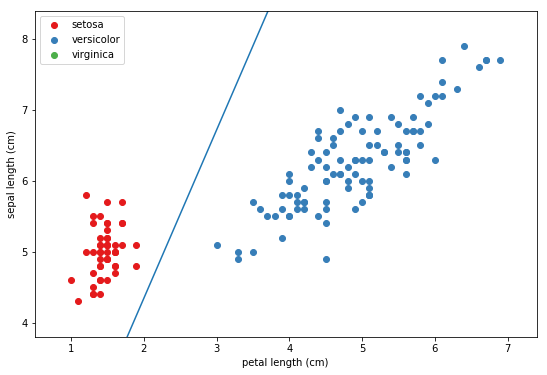

Step: 300, Loss: 27.17588410254936, Accuracy: 1.0


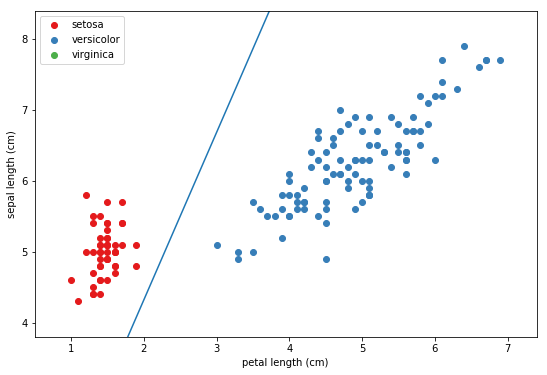

Step: 310, Loss: 26.5351197432542, Accuracy: 1.0


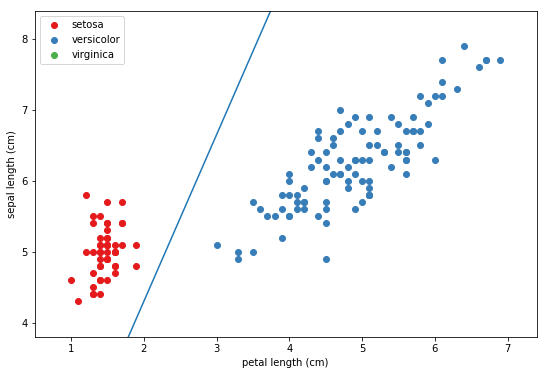

Step: 320, Loss: 25.923712819274847, Accuracy: 1.0


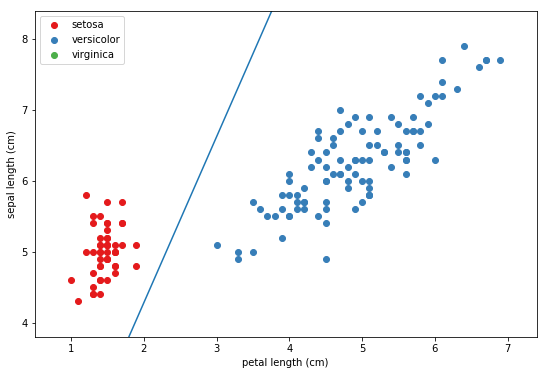

Step: 330, Loss: 25.33976977907902, Accuracy: 1.0


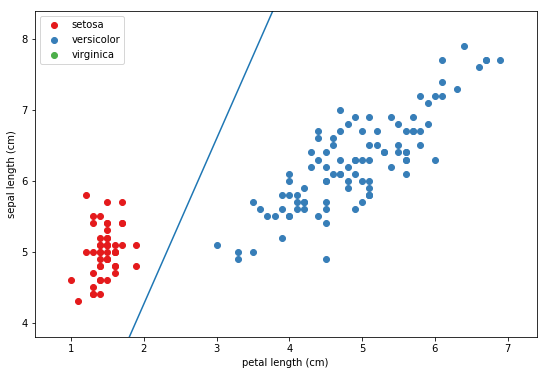

Step: 340, Loss: 24.78154906184156, Accuracy: 1.0


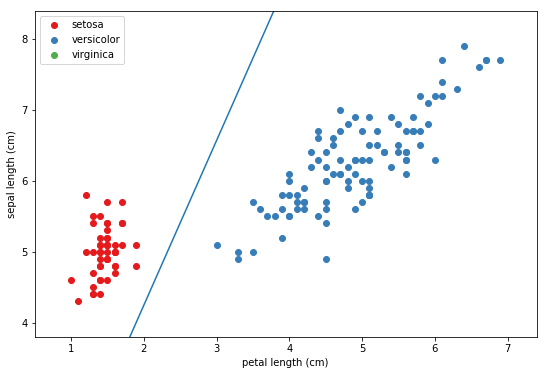

Step: 350, Loss: 24.247446931649925, Accuracy: 1.0


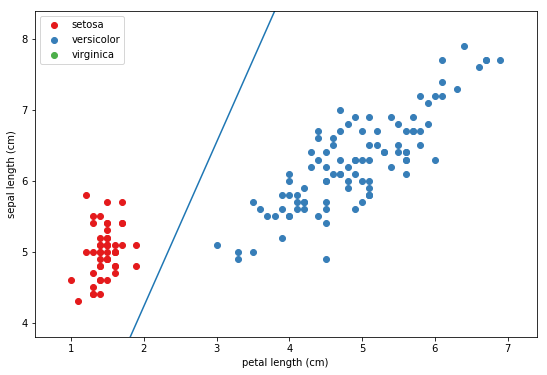

Step: 360, Loss: 23.735984770366414, Accuracy: 1.0


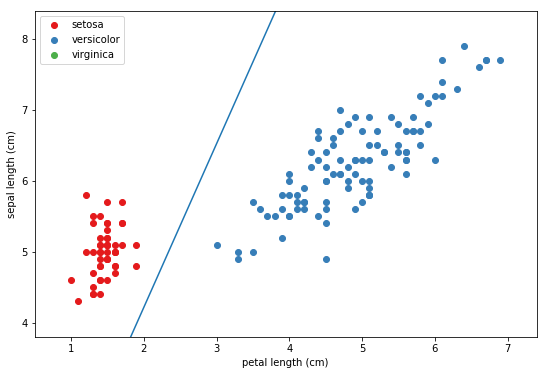

Step: 370, Loss: 23.245797670731967, Accuracy: 1.0


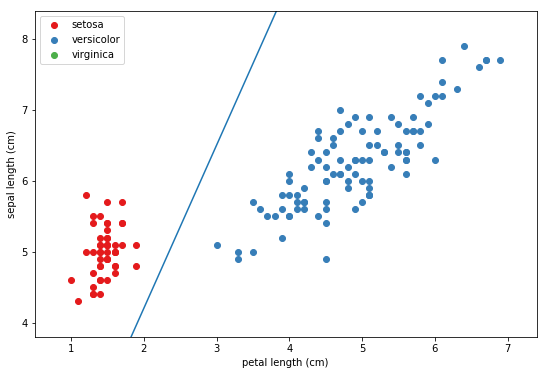

Step: 380, Loss: 22.775624188354072, Accuracy: 1.0


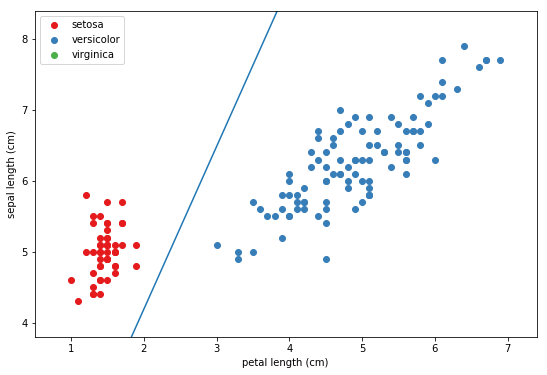

Step: 390, Loss: 22.32429712668924, Accuracy: 1.0


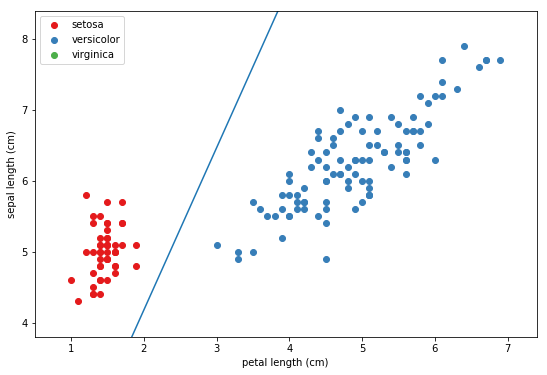

Step: 400, Loss: 21.890735243064597, Accuracy: 1.0


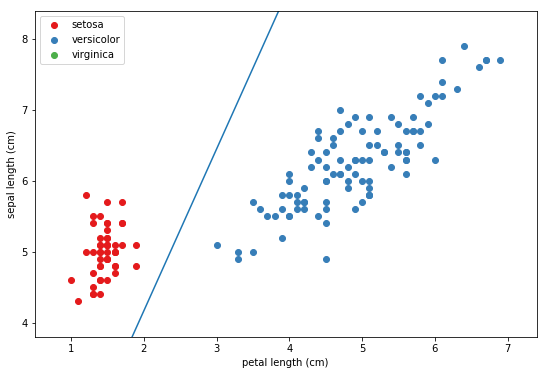

Step: 410, Loss: 21.473935776272786, Accuracy: 1.0


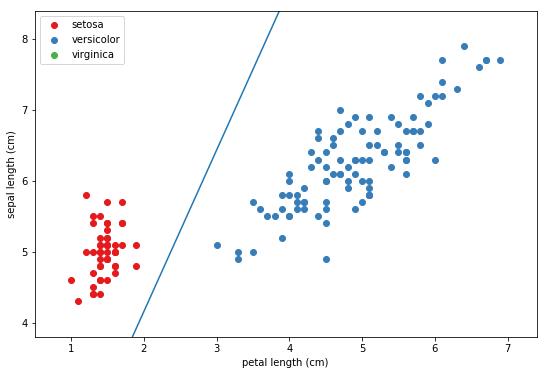

Step: 420, Loss: 21.072967707426145, Accuracy: 1.0


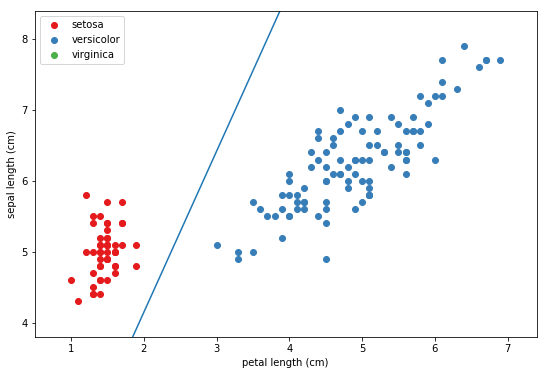

Step: 430, Loss: 20.68696567568449, Accuracy: 1.0


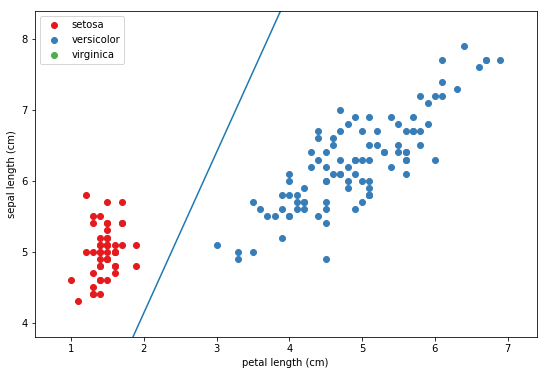

Step: 440, Loss: 20.315124479288716, Accuracy: 1.0


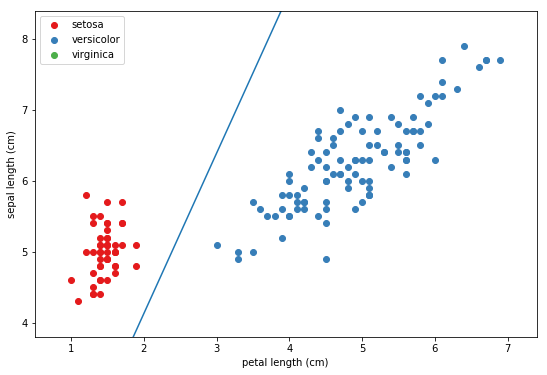

Step: 450, Loss: 19.956694100152987, Accuracy: 1.0


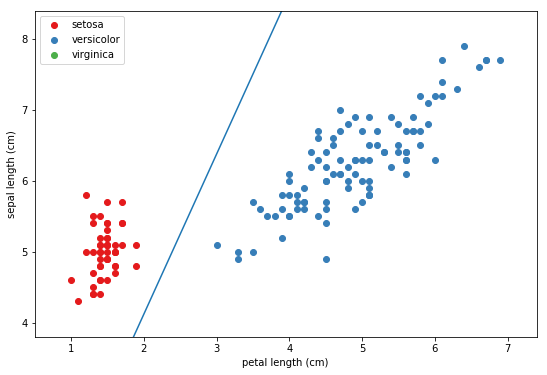

Step: 460, Loss: 19.61097519719378, Accuracy: 1.0


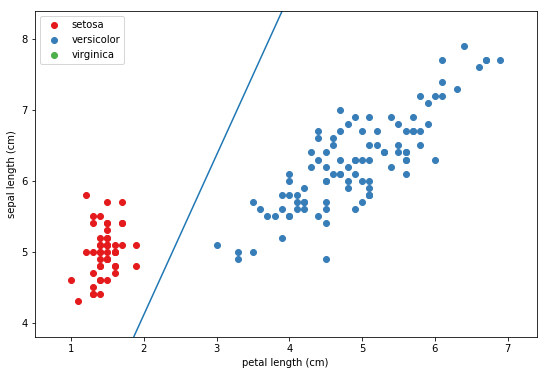

Step: 470, Loss: 19.27731501970306, Accuracy: 1.0


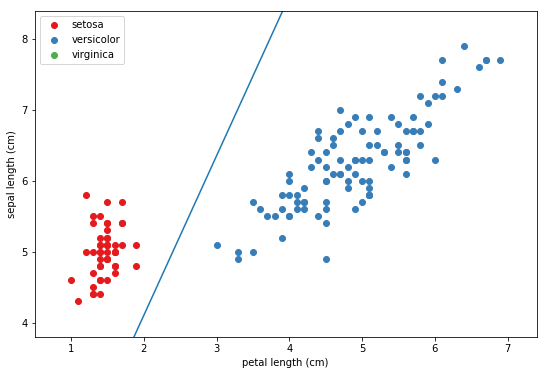

Step: 480, Loss: 18.955103697494202, Accuracy: 1.0


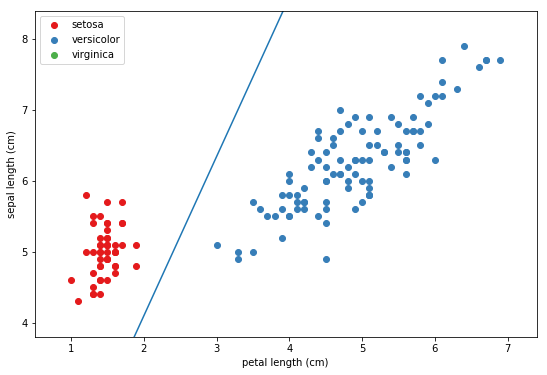

Step: 490, Loss: 18.643770869342383, Accuracy: 1.0


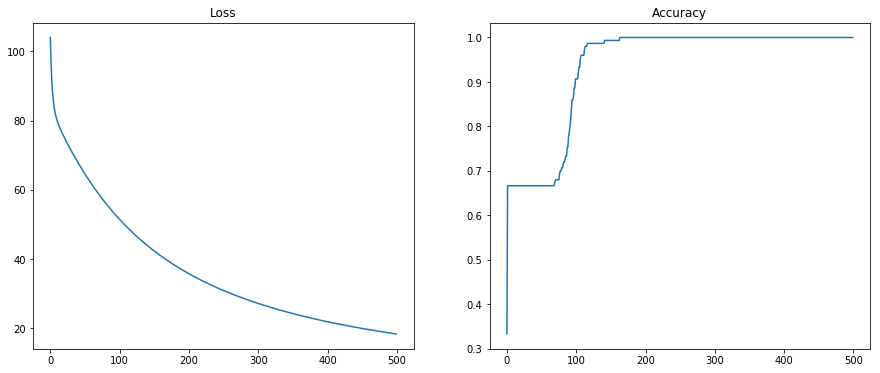

In [23]:
w = np.array([0, 0, 0])

# we define the data again
iris = datasets.load_iris()

x = iris.data
y = iris.target
y[y>0] = 1

nr_features = x.shape[1]

feature_idx_0 = 2 # choose a feature
feature_idx_1 = 0 # choose an other feature

x0 = x[:, feature_idx_0]   
x1 = x[:, feature_idx_1]

X = np.stack((x0, x1, np.ones_like(x0)), axis=-1)

# hyperparameters
nr_steps = 500
lr = 1e-4

scatter_plot(x0, x1, y, [iris.feature_names[feature_idx_0], iris.feature_names[feature_idx_1]], iris.target_names, w)

losses = []
accuracies = []

for step in range(nr_steps):
  y_hat = sigmoid(X @ w)
  
  loss = binary_cross_entropy(y_hat, y)
  losses.append(loss)
  
  accuracy = np.mean(np.round(y_hat) == y)
  accuracies.append(accuracy)
  
  gradient = bce_gradient(X, y, y_hat)

  if (step) % 10 == 0:
    scatter_plot(x0, x1, y, [iris.feature_names[feature_idx_0], iris.feature_names[feature_idx_1]], iris.target_names, w)
    print("Step: {}, Loss: {}, Accuracy: {}".format(step, loss, accuracy))
  
  w = w - lr * gradient
    

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121)
ax.set_title("Loss")
ax.plot(range(len(losses)), losses, label='Loss')
ax = fig.add_subplot(122)
ax.set_title("Accuracy")
ax.plot(range(len(accuracies)), accuracies, label="accuracy")

plt.show()